# GANocracy: A Practioner's Guide to Training GANs in 2019

**Author**: `Alex Andonian`

## Introduction

This tutorial will give a brief introduction to some of the more recent achievements of Generative Adversarial Networks (GANs), which have seen tremendous progress in their short 5 year lifespan. **Fun Fact:** GANs celebrate their 5th birthday on May 26, 2019. GANs' sucess in image synthesis is particularly impressive:

![GAN Progress in Image Synthesis](assets/progress.jpg)


As impressive as these results are, training the latest state-of-the-art GANs isn't without its challenges. For example GANs are still: 
 - sensitivive to structure and parameters/configuration
 - susceptible to model collapse
 - demanding on computational resources, especially for larger resolutions
 
The goal of this tutorial is to prepare users to take on the task of training large-scale, high-resolution GANs of their own. We will begin training a simplified version of the recent BigGAN architecture and walk through some techniques for monitoring and debugging the training process. Finally, we will demonstrate how to control sample generation using a fully pretrained BigGAN.

This tutorial assumes a basic understanding of GANs as well as a machine ready to run the latest release of PyTorch (1.1). For a general overview of GANs and how they work, please refer to [Insert Introduction Link]. For more detailed instructions on how to install PyTorch, please see these instructions [Insert Link to Setup.md].


## Setup Environment

For the **casual observer** just curious about learning more about recent GAN developments, this notebook along with the provided links to external references should be sufficient an informative document. A powerful laptop or mainstream desktop computer should be enough for you to execute most of the computationally inexpensive (e.g. inference with pretrained generators) cells.

For the **interested practioner** keen on running the full notebook and playing around with different datasets and hyperparameters, a powerful desktop/server with at least one modern GPU is *highly* recommended, if not required. The median recommendation is 4-8 GPUs.

If you do not have access to the recommended computational resources, it is possible (and fairly easy) to create a sufficiently powerful Virtual Machine (VM) on one of several cloud providers. We provide brief instructions and suggestions on how to get up and running with the following providers:

- [Core Scientific] TODO
- [Google Cloud] TODO
- [IBM Cloud] TODO

Nvidia and AWS also provide excellent options, but we are not able to provide specific instructions at this time.

For the **hardcore "GANologist"** determined to reproduce (and exceed) the performance of the latest state-of-the-art GANs, we recommend using this notebook as a thorough introduction and reference before stepping up to full-fledged (officially unofficial) implementations such as [BigGAN-PyTorch](https://github.com/ajbrock/BigGAN-PyTorch)

### System & Software Requirements
Both Linux and Windows machines are supported, but we strongly recommend Linux for performance and compatibility reasons. 

- PyTorch, version 1.1 (stable)
- tqdm, numpy, scipy, h5py

### Recommendations


In [1]:
# IMPORTS
import os 
import sys
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

# GANOCRACY LIB
sys.path.append('../')
import ganocracy
from ganocracy.data import datasets as dset
from ganocracy.data import transforms
from ganocracy.utils import visualizer as vutils
from ganocracy import metrics

# NOTEBOOK-SPECIFIC IMPORTS
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [17]:
config = {

    # DATA CONFIG
    'data_root': 'data',            # Root directory where datasets are stored
    'dataset': 'ImageNet',          # Name of dataset 
    'dataset_type': 'ImageHDF5',    # Type/format of dataset class used to load data.
    'parallel': True,
    'shuffle': True,                # Shuffle training data
    'batch_size': 512,              
    'num_workers': 8,
    'load_in_mem': True,
    'resolution': 64,
    'download': True,
    'split': 'train',
    
    # MODEL ARCHITECTURE
    'GAN_type': 'DCGAN',  # Type of GAN. Choices: ['DCGAN', 'SNGAN', 'SAGAN', 'BigGAN', 'BigGANDeep']
    'G_ch': 96,
    'D_ch': 96,
    'G_attn': 64,
    'D_attn': 64,
    'hier': True,
    'dim_z': 120,
    'shared_dim': 128,
    'G_init': 'ortho',
    'D_init': 'ortho',
    'G_n1': 'inplace_relu',
    'D_n1': 'inplace_relu',
    'G_eval_mode': True,
    'ngpu': 1,
  
    
    # TRAINING CONFIG     
    'num_D_steps': 1,
    'num_G_accumulations': 4,
    'num_D_accumulations': 4,
    'G_lr': 1e-4,
    'D_lr': 4e-4,
    'G_betas': (0.5, 0.999),
    'D_betas': (0.5, 0.999),
    'loss_type': 'BCE',

    'ema': True,
    'use_ema': True,
    'ema_start': 20000,
    'test_every': 2000,
    'save_every': 1000,
    'num_best_copies': 5,
    'num_save_copies': 2,
    'seed': 0,
    'use_multiepoch_sampler': True,
}

config.update({
    # Update with standard number of classes
    # based on choice of dataset.
    'num_classes': {
        'celeba': 1,
        'CIFAR10': 10,
        'CIFAR100': 100,
        'ImageNet': 1000,
        'Places365': 365,
    }.get(config['dataset'], 1),
    
    # Prepare data; the Discriminator's batch size is all that needs to be passed
    # to the dataloader, as G doesn't require dataloading.
    # Note that at every loader iteration we pass in enough data to complete
    # a full D iteration (regardless of number of D steps and accumulations)
    'D_batch_size': config['batch_size'] * config['num_D_steps'] * config['num_D_accumulations'],
    
    'device': torch.device("cuda:0" if (torch.cuda.is_available() and config['ngpu'] > 0) else "cpu")
})

## Data Preparation
In this tutorial, we will use the [Places365 dataset](http://places2.csail.mit.edu/) which contains more than 10 million images comprising 400+ unique scene categories. You can manually download the full dataset [here](http://places2.csail.mit.edu/download.html), although we provide standard PyTorch dataloaders that download, cache and preprocess several standard datasets as part of this tutorial. Therefore, preparing a dataloader can be accomplished with just a few lines:

In [3]:
def get_dataset(name, root_dir=None, resolution=128, filetype='tar'):
    if filetype == 'tar':
        url = dset.data_urls[name]['tar']
        data_dir = dset.load_data_from_url(url, root_dir)
        dataset = dset.ImageFolder(root=data_dir,
                                   transform=transforms.Compose([
                                       transforms.CenterCropLongEdge(),
                                       transforms.Resize(resolution),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5),
                                                            (0.5, 0.5, 0.5))
                                    ]))
    elif filetype == 'hdf5':
        url = dset.data_urls[name]['hdf5'][resolution]
        hdf5_file = dset.load_data_from_url(url, root_dir)
        dataset = dset.ImageHDF5(hdf5_file)
    else:
        raise ValueError('Unreconized filetype: {}'.format(filetype))
    return dataset

# dataset = get_dataset(config['dataset'],
#                       root_dir=config['data_root'],
#                       resolution=config['resolution'])

# dataloader = torch.utils.data.DataLoader(dataset,
#                                          shuffle=config['shuffle'],
#                                          batch_size=config['batch_size'],
#                                          num_workers=config['num_workers'])
# vutils.visualize_data(dataloader)



In [4]:
# resolution = config['resolution']
# dataset = torchvision.datasets.ImageNet(config['data_root'],
#                                         split=config['split'],
#                                         download=config['download'],
#                                         transform=transforms.Compose([
#                                             transforms.CenterCropLongEdge(),
#                                             transforms.Resize(resolution),
#                                             transforms.ToTensor(),
#                                             transforms.Normalize((0.5, 0.5, 0.5),
#                                                                  (0.5, 0.5, 0.5))
#                                     ]))

First, we will need to organize and preprocess the training data that will serve as the 'real' examples presented to the discriminator. If you are training an unconditional GAN with only a single class of images, it would be enough to simply store all of your examples in a directory like so:

    satellite_images/34_-77_2016-02-28.png
    satellite_images/34_-77_2014-06-29.png
    satellite_images/36_-75_2008-07-13.png
    satellite_images/30_-84_2010-07-11.png
    satellite_images/27_-97_2010-07-18.png
    
If you are training a class-conditional GAN such as SA-GAN or BigGAN, it is fairly common to store images organized as so:

    root/dogball/xxx.png
    root/dogball/xxy.png
    root/dogball/xxz.png

    root/cat/123.png
    root/cat/nsdf3.png
    root/cat/asd932_.png

### Prepare data as single HDF5 file (optional, for additional performance)

If your dataset consists of large, high-resolution images, then repeatedly applying transforms to the raw images (cropping, resizing) results in many wasted CPU cycles. Furthermore, increasing your batchsize puts additional I/O strain on your filesystem. Together, these factors may produce a dataloading bottleneck where your GPUs consume data faster than your system can produce it. To remedy this, you may choose to prepare a pre-processed HDF5 version of your target dataset using the utilities provided. Moreover, if I/O still appears to be the bottleneck, you may choose to load the entire dataset into RAM by setting `load_in_mem` dataset kwargs to `True` (if your system can support this).

Another advantage to using a single, preprocessed HDF5 is the ease with which you can transfer data to multiple remote machines, which normally becomes cumbersome and time consuming when attempting large, distributed experiments.

ImageNet-64.hdf5
data/ImageNet-64.hdf5
Loading data/ImageNet-64.hdf5 into memory...


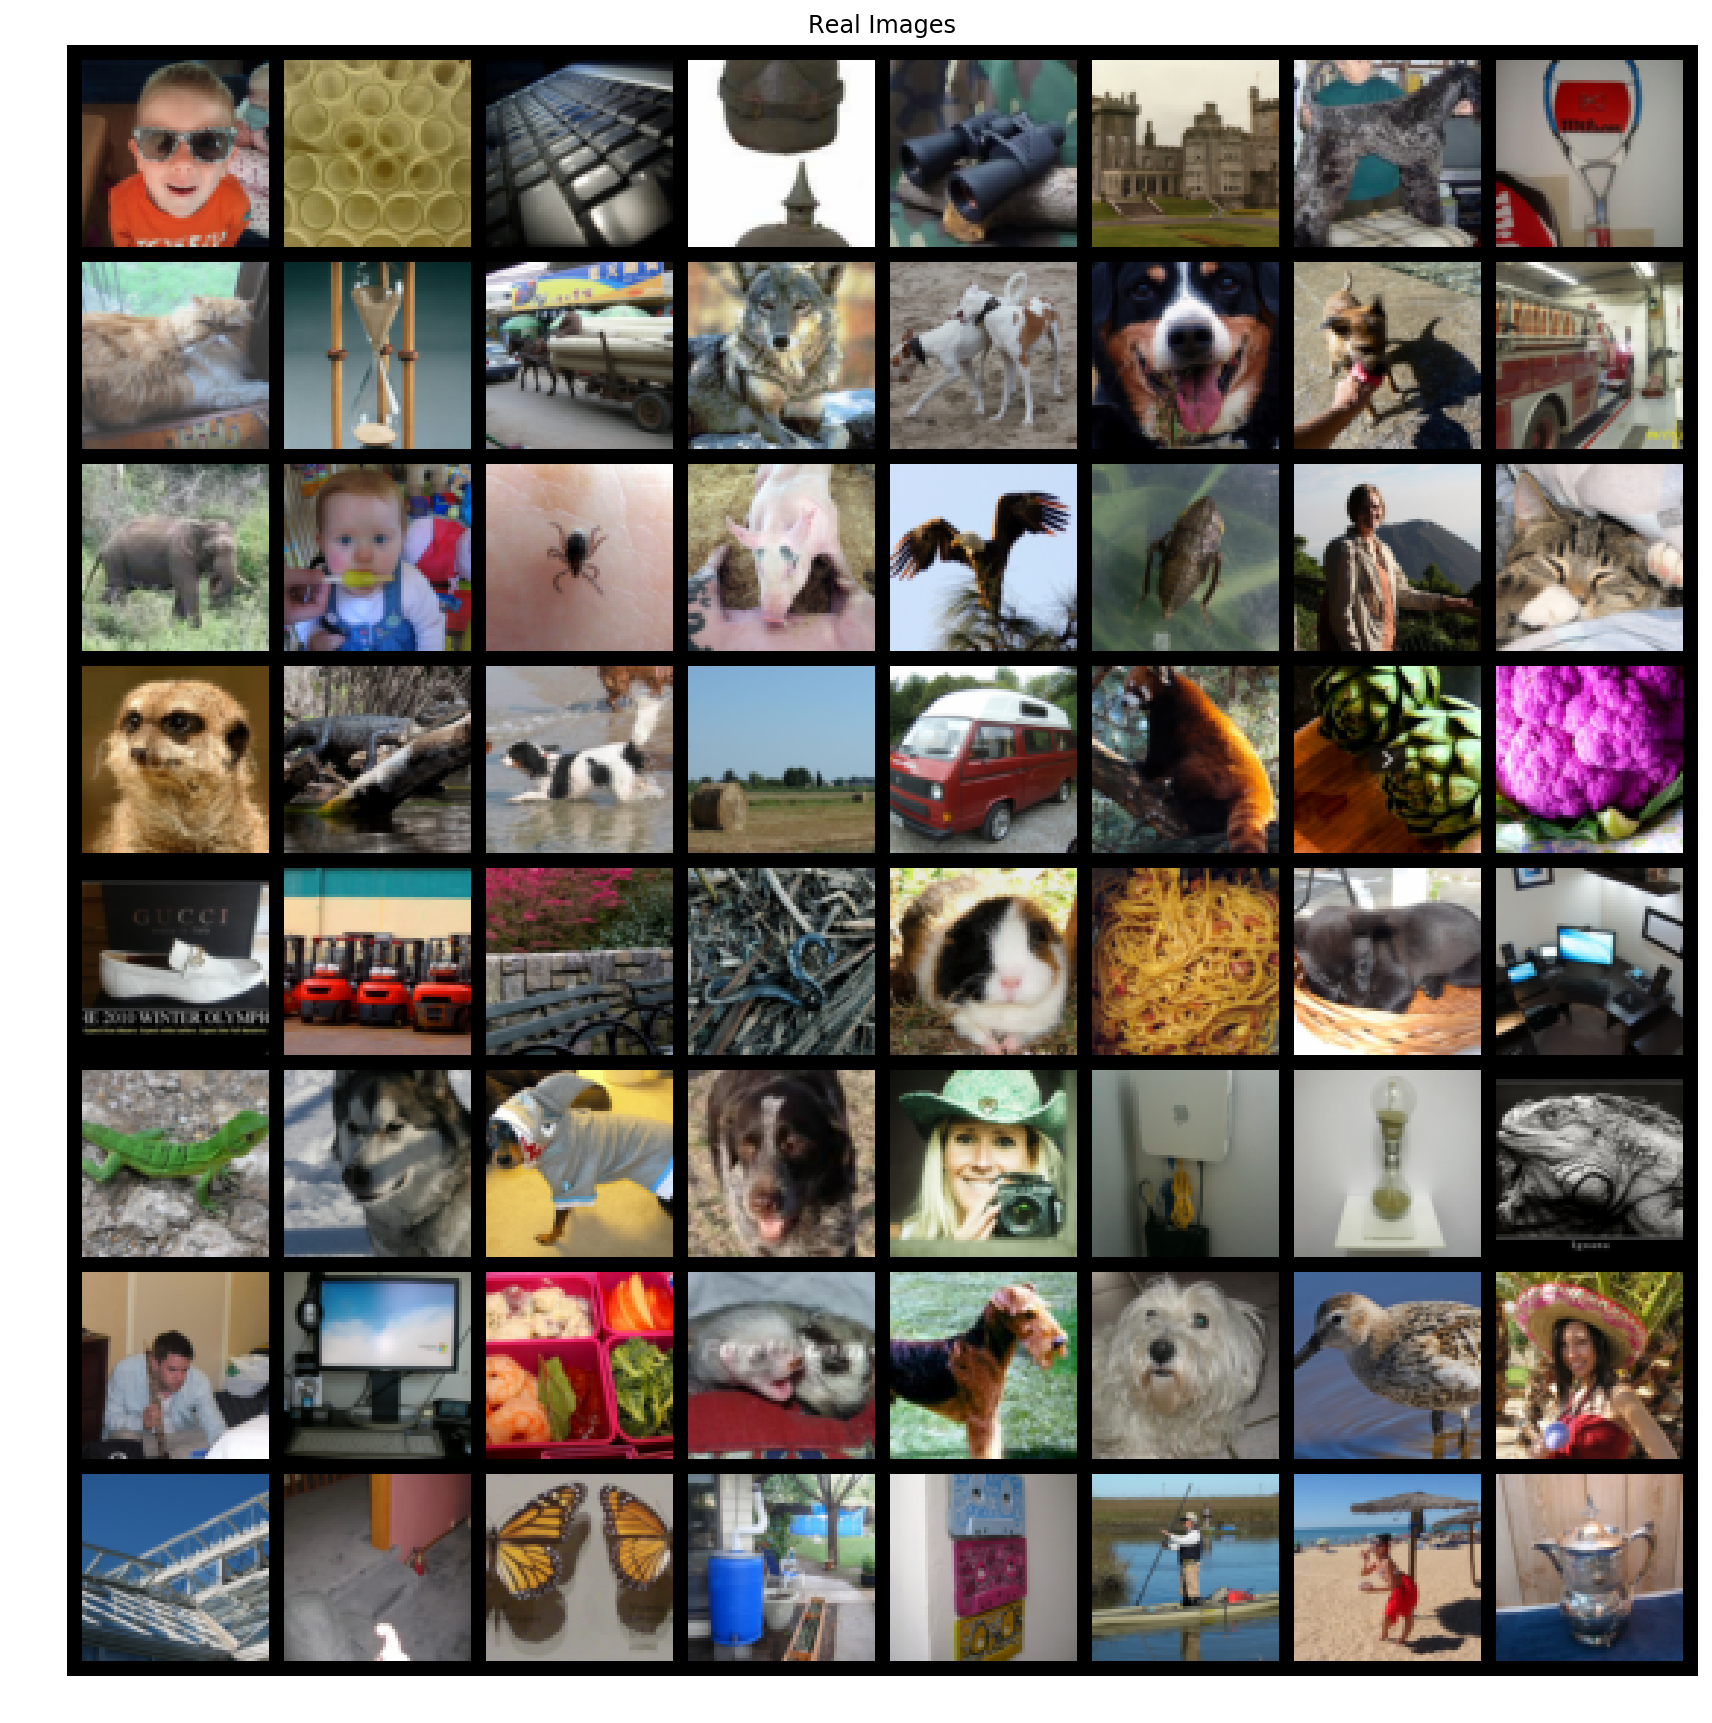

In [5]:
hdf5_name = '{}-{}.hdf5'.format(config['dataset'], config['resolution'])
print(hdf5_name)
hdf5_file = os.path.join(config['data_root'], hdf5_name)
print(hdf5_file)
# hdf5_file = dset.make_hdf5(dataloader, config['data_root'], hdf5_name)
dataset = dset.ImageHDF5(hdf5_file, load_in_mem=config['load_in_mem'])
dataloader = torch.utils.data.DataLoader(dataset,
                                         shuffle=config['shuffle'],
                                         batch_size=config['D_batch_size'],
                                         num_workers=config['num_workers'])
vutils.visualize_data(dataloader)

### Preparing to measure sample quality during training

Typically, when training any sort of neural network, it is standard practice to monitor the value of the objective function (loss) throughout the course of the experiment. With GANs, it is also common to break the loss into individual components.

Objectively evaluating implicit generative models is difficult (Theis et al., 2015). A variety of works
have proposed heuristics for measuring the sample quality of models without tractable likelihoods
(Salimans et al., 2016; Heusel et al., 2017; Binkowski et al., 2018; Wu et al., 2017). Of these, ´
the Inception Score (IS, Salimans et al. (2016)) and Frechet Inception Distance (FID, Heusel et al. ´
(2017)) have become popular despite their notable flaws (Barratt & Sharma, 2018). We employ
them as approximate measures of sample quality, and to enable comparison against previous work.

While training, it would be very useful to objectively measure the quality of generated samples in order to understand how training is progressing (without having to manually assign subjective ratings to a large. Moreover,  To this end, researchers have developed metrics which seek to capture the quality of the generated samples, with the two most popular being:
- Inception Score (IS)
- Frechet Distance (FID)


Higher IS values mean better image quality, but not necessarily diversity.
Lower FID values mean better image quality and diversity.

or datasets other than ImageNet, Inception Score can be a very poor measure of quality, so you will likely want to use --which_best FID instead.

In [6]:
# inception_moments_file = metrics.calculate_inception_moments(dataloader, config['data_root'], config['dataset'])

# Build Model

## Convolutional GANS 

[Deep Convolutional GANS](https://arxiv.org/abs/1511.06434) (DCGANs) represented a major step forward in the sucess of GAN image synthesis. The introduction of convolutional layers, which had already proven successful for disciminative computer vision tasks
Structure well suited for image generatation.
When applied to images, G and D are usually convolutional neural networks (Radford et al., 2016).
![DCGAN Generator Architecure](assets/dcgan_generator.png)

Almost all GANs used for image synthesis now follow some variation of DCGAN.
- GBlock
- DBlock


The generator consists of GBlocks, which progressively increase the spatial dimensions while decreasing the feature volume depth.

Batch norm follows the transposed Convolution, which works to combat poor initialization schemes and mode collapes. *Recall, batch norm works by normalizing the inputs features to have zero mean and unit variance.*

*Mode Collapse*: When the generator falls into a situation where it produces an extremely limited set output patterns ("modes") despite maintaining diversity on input noise. 

In [7]:
class GBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU(True)
        
    def forward(self, input):
        """Forward method of GBlock.
        
        This block increases the spatial resolution by 2:
        
            input:  [batch_size, in_channels, H, W]
            output: [batch_size, out_channels, 2*H, 2*W]
        """
        
        x = self.conv(input)
        x = self.bn(x)
        out = self.act(x)
        return out

DBlocks, found in the discriminator, are near perfect inverses to GBlocks, trading spatial dimension for feature depth, with the exception of using 

In [8]:
class DBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(0.2, inplace=True)
        
    def forward(self, x):
        """Forward method of DBlock.
        
        This block decreases the spatial resolution by 2:
        
            input:  [batch_size, in_channels, H, W]
            output: [batch_size, out_channels, H/2, W/2]
        """
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x
    

## Conditional GANs
Produce images of 

In [9]:
class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, num_classes, eps=1e-4, momentum=0.1):
        super().__init__()
        self.num_features = num_features
        self.bn = nn.BatchNorm2d(num_features, affine=False, eps=eps, momentum=momentum)
        self.gamma_embed = nn.Linear(num_classes, num_features, bias=False)
        self.beta_embed = nn.Linear(num_classes, num_features, bias=False)

    def forward(self, x, y):
        # First, compute standard batchnorm stats.
        out = self.bn(x)
        
        # Learn class specific scale and shift.
        gamma = self.gamma_embed(y) + 1
        beta = self.beta_embed(y)
        out = gamma.view(-1, self.num_features, 1, 1) * out + beta.view(-1, self.num_features, 1, 1)
        return out

consider swapping ccbn and SN

## Spectral Normalization (Stability)

https://arxiv.org/abs/1802.05957


**Problem**: GAN training is highly dynamic ()

Miyato et al proposed a normalization technique called spectral normalization (SN), which enforces Lipschitz continuity on the weights of the discriminator (and generator).

Briefly, Lipschitz continuity relates to how quickly a function can change. For example, every function that has bounded first derivatives is Lipschitz, and the smallest such bound is called the Lipschitz constant. 

Spectral normed layers enforce Lipschitz continuity by normalizing its parameters with running estimates of their frist singular values.  These estimates can be computed using the power iteration method described below:

![spectral normalization algorithm](assets/spectral_norm_algorithm.png)

Originally shown to be useful in D, but later also shown to improve stability in G, allowing for fewer D steps per iteration.
(**Note**: Numerous t)

## Self-Attention Mechanism (Diversity)

First proposed by the GANfather, Ian Goodfellow himself, in the paper [Self-Attention Generative Adversarial Networks](https://arxiv.org/abs/1805.08318)(SA-GANs), the introduction of a self-attention mechanism to GANs is aimed at

### Observation and Inspiration
Prior to SA-GANs, researchers noticed that while vanilla DCGAN-style GANs continued to improve on datasets with limited number of classes (such as faces), they still stuggled to learn the image distributions of diverse multi-class datasets like Imagenet. 

convolutions are (spatially) local operations, with the extend of spatial dependencies (receptive field) limited by the kernel size. Thus, capturing long-range (non-local) dependenices is not really possible since the outputs of a convolution at one spatial location have no effect on the outputs at another distant location.

Possible solutions:

- increase kernel size (slow and inefficient)
- deeper network (more layers) so that later layers have larger receptive fields (more parameters, more difficult to train)




![Self-Attention GAN regions attended](assets/sagan_regions.png)


![Self-Attention Block](assets/sa_block.png)


In [20]:
class Attention(nn.Module):
    def __init__(self, ch, conv_func=nn.Conv2d, name='attention'):
        super(Attention, self).__init__()
        # Channel multiplier
        self.ch = ch
        self.conv_func = conv_func
        self.theta = self.conv_func(self.ch, self.ch // 8, kernel_size=1, padding=0, bias=False)
        self.phi = self.conv_func(self.ch, self.ch // 8, kernel_size=1, padding=0, bias=False)
        self.g = self.conv_func(self.ch, self.ch // 2, kernel_size=1, padding=0, bias=False)
        self.o = self.conv_func(self.ch // 2, self.ch, kernel_size=1, padding=0, bias=False)
        
        # Learnable gain parameter
        self.gamma = P(torch.tensor(0.), requires_grad=True)
        
    def forward(self, x, y=None):
        # Apply convs
        theta = self.theta(x)
        phi = F.max_pool2d(self.phi(x), [2,2])
        g = F.max_pool2d(self.g(x), [2,2])
        
        # Perform reshapes
        theta = theta.view(-1, self. ch // 8, x.shape[2] * x.shape[3])
        phi = phi.view(-1, self. ch // 8, x.shape[2] * x.shape[3] // 4)
        g = g.view(-1, self. ch // 2, x.shape[2] * x.shape[3] // 4)
        
        # Matmul and softmax to get attention maps
        beta = F.softmax(torch.bmm(theta.transpose(1, 2), phi), -1)
        
        # Attention map times g path
        o = self.o(torch.bmm(g, beta.transpose(1,2)).view(-1, self.ch // 2, x.shape[2], x.shape[3]))
        return self.gamma * o + x



## Scaling Up GANs

### Batch Size
Simply increasing the batch size by a factor of 8 improves the state-of-the-art IS by 46%. We conjecture that this is a result of each batch covering more modes, providing better gradients for both networks.

### Number of channels
We then increase the width (number of channels) in each layer by 50%, approximately doubling the
number of parameters in both models. This leads to a further IS improvement of 21%, which we
posit is due to the increased capacity of the model relative to the complexity of the dataset

## two-timescale update rule (TTUR)

## Exponential Moving Average (EMA)
We use an exponential moving average of the weights of G at sampling time, with a decay rate set to
0.9999

## Gradient Accumulations

### Putting it all together
![BigGAN Architecture](assets/biggan_arch.png)

In [10]:
class DCGANGenerator(nn.Module):
    """DCGAN Generator.
    """
    
    # Maps output resoluton to number of GBlocks.
    res2blocks = {
        32: 3,
        64: 4,
        128: 5,
        256: 6,
    }
    
    def __init__(self, dim_z=128, resolution=128, G_ch=64, 
                block=GBlock):
        super().__init__()
        
        self.G_ch = G_ch
        self.dim_z = dim_z

        self.num_blocks = self.res2blocks[resolution]
        self.ch_nums = [2**i for i in range(self.num_blocks)]
        self.ch_nums += self.ch_nums[-1:]
        self.ch_nums = list(reversed(self.ch_nums))
        
        self.linear = nn.Linear(dim_z, G_ch * self.ch_nums[0] * 4**2)
        self.GBlocks = nn.Sequential(*[
            block(G_ch * in_c, G_ch * out_c)
            for in_c, out_c in zip(self.ch_nums, self.ch_nums[1:])
        ])
        self.out = nn.Conv2d(G_ch * 1, 3, 3, padding=1)  # RGB image has 3 channels
        self.tanh = nn.Tanh()                            # "Squashes" out to be in range[-1, 1]
    
    def forward(self, x):
        x = self.linear(x)
        x = x.view(x.size(0), -1, 4, 4)
        x = self.GBlocks(x)
        return self.tanh(self.out(x))
    
dim_z = 128
z = torch.rand(10, config['dim_z'])
G = DCGANGenerator(dim_z=config['dim_z'], resolution=config['resolution'])
print(G)
print('output shape:', G(z).shape)

DCGANGenerator(
  (linear): Linear(in_features=120, out_features=8192, bias=True)
  (GBlocks): Sequential(
    (0): GBlock(
      (conv): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace)
    )
    (1): GBlock(
      (conv): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace)
    )
    (2): GBlock(
      (conv): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace)
    )
    (3): GBlock(
      (conv): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-0

In [11]:
# Generator Code

class GBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_features):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False)
        self.bn = ConditionalBatchNorm2d(out_channels, num_features)
        self.act = nn.ReLU(True)
        
    def forward(self, x, y):
        x = self.conv(x)
        x = self.bn(x, y)
        x = self.act(x)
        return x
    
class Generator(nn.Module):
    res2blocks = {
        32: 3,
        64: 4,
        128: 5,
        256: 6,
    }
    def __init__(self, dim_z=128, num_classes=2, resolution=128, G_ch=64, class_dim=128):
        super(Generator, self).__init__()

        self.G_ch = G_ch
        self.dim_z = dim_z
        self.class_dim = class_dim
        self.num_classes = num_classes

        
        self.num_blocks = self.res2blocks[resolution]
        self.fnums = [2**i for i in range(self.num_blocks)]
        self.fnums += self.fnums[-1:]
        self.fnums = list(reversed(self.fnums))
        
        self.class_linear = nn.Linear(num_classes, class_dim)
        self.linear = nn.Linear(dim_z, G_ch * self.fnums[0] * 4**2)
        
        self.GBlocks = nn.ModuleList ([
            GBlock(G_ch * in_c, G_ch * out_c, class_dim)
            for in_c, out_c in zip(self.fnums, self.fnums[1:])])

        self.out = nn.Conv2d(G_ch * 1, 3, 3, padding=1)
        self.tanh = nn.Tanh()
    
    def forward(self, z, y):
        class_embed = self.shared(y)
        return self.generate(z, class_embed)

    
    def shared(self, y):
        y = self.onehot(y, self.num_classes)
        return self.class_linear(y)
    
    def generate(self, z, class_embed):
        z = self.linear(z).view(z.size(0), -1, 4, 4)
        for block in self.GBlocks:
            z = block(z, class_embed)
        return self.tanh(self.out(z))
    
    def onehot(self, y, num_classes):
        """Transform int labels to onehot tensor, if needed.
        
        Args:
            y (torch.Tensor): Class labels (either ints or onehot).
                size: [batch_size,] or [batch_size, num_classes]
            num_classes: Total number of classes.
            
        Returns:
            torch.Tensor: onehot representation of class targets.
        
        """
        y = y.squeeze()
        if y.dim() == 1:
            y = y.unsqueeze(-1)
            y = torch.zeros((y.size(0), num_classes),
                            device=y.device).scatter(1, y.long(), 1)
        return y
    
    

dim_z = 128
z = torch.rand(4, dim_z)
y = torch.ones(4) * 1
G = Generator(dim_z=dim_z)   
print(G)
print(G(z, y).shape)

Generator(
  (class_linear): Linear(in_features=2, out_features=128, bias=True)
  (linear): Linear(in_features=128, out_features=16384, bias=True)
  (GBlocks): ModuleList(
    (0): GBlock(
      (conv): ConvTranspose2d(1024, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): ConditionalBatchNorm2d(
        (bn): BatchNorm2d(1024, eps=0.0001, momentum=0.1, affine=False, track_running_stats=True)
        (gamma_embed): Linear(in_features=128, out_features=1024, bias=False)
        (beta_embed): Linear(in_features=128, out_features=1024, bias=False)
      )
      (act): ReLU(inplace)
    )
    (1): GBlock(
      (conv): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): ConditionalBatchNorm2d(
        (bn): BatchNorm2d(512, eps=0.0001, momentum=0.1, affine=False, track_running_stats=True)
        (gamma_embed): Linear(in_features=128, out_features=512, bias=False)
        (beta_embed): Linear(in_features=128,

In [12]:
class Discriminator(nn.Module):
    """DCGAN discriminator."""
    
    # Maps output resoluton to number of DBlocks.
    res2blocks = {
        32: 3,
        64: 4,
        128: 5,
        256: 6,
    }
    
    def __init__(self, resolution=128, D_ch=64, block=DBlock):
        super().__init__()
        self.D_ch = D_ch
        self.num_blocks = self.res2blocks[resolution]
        self.fnums = [2**i for i in range(self.num_blocks)]
        self.input_layer = nn.Conv2d(3, D_ch, 3, padding=1)
        
        self.DBlocks = nn.Sequential(*[
            block(D_ch * in_c, D_ch * out_c)
            for in_c, out_c in zip(self.fnums, self.fnums[1:])
        ])
        
        self.out = nn.Conv2d(D_ch * self.fnums[-1], 1, 3, 1, 0)
        self.act = nn.Sigmoid()
    
    def forward(self, x):
        x = self.input_layer(x)
        x = self.DBlocks(x)
        x = self.act(torch.mean(self.out(x), [2, 3]))
        return x

    
x = torch.rand(10, 3, config['resolution'], config['resolution'])
D = Discriminator(resolution=config['resolution'])
print(D)
print('output shape:', D(x).shape)

Discriminator(
  (input_layer): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (DBlocks): Sequential(
    (0): DBlock(
      (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): LeakyReLU(negative_slope=0.2, inplace)
    )
    (1): DBlock(
      (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): LeakyReLU(negative_slope=0.2, inplace)
    )
    (2): DBlock(
      (conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): LeakyReLU(negative_slope=0.2, inplace)
    )
  )
  (out): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1))
  (act): Sigmoid()
)
output sh

In [13]:
# Create the generator
netG = Generator(dim_z=config['dim_z'],
                 num_classes=config['num_classes'],
                 resolution=config['resolution']).to(config['device'])

# Create the Discriminator
netD = Discriminator(resolution=config['resolution']).to(config['device'])

# Handle multi-gpu if desired
if (config['device'].type == 'cuda') and (config['ngpu'] > 1):
    netG = nn.DataParallel(netG, list(range(config['ngpu'])))
    netD = nn.DataParallel(netD, list(range(config['ngpu'])))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
# netG.apply(weights_init)
# netD.apply(weights_init)

# Print the model
print(netG)
print(netD)

Generator(
  (class_linear): Linear(in_features=1000, out_features=128, bias=True)
  (linear): Linear(in_features=120, out_features=8192, bias=True)
  (GBlocks): ModuleList(
    (0): GBlock(
      (conv): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): ConditionalBatchNorm2d(
        (bn): BatchNorm2d(512, eps=0.0001, momentum=0.1, affine=False, track_running_stats=True)
        (gamma_embed): Linear(in_features=128, out_features=512, bias=False)
        (beta_embed): Linear(in_features=128, out_features=512, bias=False)
      )
      (act): ReLU(inplace)
    )
    (1): GBlock(
      (conv): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): ConditionalBatchNorm2d(
        (bn): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=False, track_running_stats=True)
        (gamma_embed): Linear(in_features=128, out_features=256, bias=False)
        (beta_embed): Linear(in_features=128, out

In [ ]:
class DCGAN(nn.Module):
    
    def __init__(self, config):
        self.config = config
        self.G = DCGANGenerator()

In [18]:
# Setup Adam optimizers for both G and D
netD.optim = optim.Adam(netD.parameters(), lr=config['D_lr'], betas=config['G_betas'])
netG.optim = optim.Adam(netG.parameters(), lr=config['G_lr'], betas=config['D_betas'])

In [ ]:
gan = DCGANG(config)

for epoch in range(config['num_epochs']):
    for i, (x, y) in enumerate(dataloader):
    
        
        gan.D.zero_grad()
        real_labels = torch.full((config['batch_size'],), 1, device=config['device'])
        
        D_real = gan.D(x)
        D_loss_real = criterion(D_real, real_labels)
        
        z = torch.randn(config['batch_size'], config['dim_z'], device=config['device'])
        gy = torch.LongTensor(config['batch_size'], 1).random_() % config['num_classes']
        G_z = gan.G(z, gy)
        D_fake = gan.D(G_z, gy)
        D_loss_fake = criterion(D_fake, real_labels-1)
        D_loss = D_loss_real + D_loss_fake
        D_loss.backward()
        gan.D.optim.step()
        

In [ ]:
# MAIN TRAINING FUNCTION
def GAN_training_function(G, D, GD, z_, y_, ema, state_dict, config):
    def train(x, y):
        G.optim.zero_grad()
        D.optim.zero_grad()
        # How many chunks to split x and y into?
        x = torch.split(x, config['batch_size'])
        y = torch.split(y, config['batch_size'])
        counter = 0

        # Optionally toggle D and G's "require_grad"
        if config['toggle_grads']:
            utils.toggle_grad(D, True)
            utils.toggle_grad(G, False)

        ###############################################################
        #                    TRAIN DISCRIMINATOR
        ###############################################################
        for step_index in range(config['num_D_steps']):
            # If accumulating gradients, loop multiple times before an optimizer step
            for accumulation_index in range(config['num_D_accumulations']):
                z_.sample_(), y_.sample_()
                D_fake, D_real = GD(z_[:config['batch_size']], y_[:config['batch_size']],
                                    x[counter], y[counter], train_G=False,
                                    split_D=config['split_D'])

                # Compute components of D's loss, average them, and divide by
                # the number of gradient accumulations.
                D_loss_real, D_loss_fake = losses.discriminator_loss(D_fake, D_real)
                D_loss = (D_loss_real + D_loss_fake) / float(config['num_D_accumulations'])
                D_loss.backward()
                counter += 1

            # Optionally apply ortho reg in D.
            if config['D_ortho'] > 0.0:
                # Debug print to indicate we're using ortho reg in D.
                print('using modified ortho reg in D')
                utils.ortho(D, config['D_ortho'])

            D.optim.step()

        # Optionally toggle "requires_grad"
        if config['toggle_grads']:
            utils.toggle_grad(D, False)
            utils.toggle_grad(G, True)

        # Zero G's gradients by default before training G, for safety.
        G.optim.zero_grad()

        ###############################################################
        #                    TRAIN GENERATOR
        ###############################################################
        # If accumulating gradients, loop multiple times.
        for accumulation_index in range(config['num_G_accumulations']):
            z_.sample_(), y_.sample_()
            D_fake = GD(z_, y_, train_G=True, split_D=config['split_D'])
            G_loss = losses.generator_loss(D_fake) / float(config['num_G_accumulations'])
            G_loss.backward()

        # Optionally apply modified ortho reg in G.
        if config['G_ortho'] > 0.0:
            print('using modified ortho reg in G')  # Debug print to indicate we're using ortho reg in G.
            # Don't ortho reg shared, it makes no sense. Really we should blacklist any embeddings for this...
            utils.ortho(G, config['G_ortho'],
                        blacklist=[param for param in G.shared.parameters()])
        G.optim.step()

        # If we have an ema, update it, regardless of if we test with it or not.
        if config['ema']:
            ema.update(state_dict['itr'])

        out = {'G_loss': float(G_loss.item()),
               'D_loss_real': float(D_loss_real.item()),
               'D_loss_fake': float(D_loss_fake.item())}
        return out
    return train


### And we're off!

... And now we wait. At lower resolutions or fewer classes, it is possible to obtain farily respectable results in a short time frames. However, acheiving  the eye-catching results commonly advertised in paper and the media still takes quite a while, on the order of weeks potentially. 

Below is a table of some fairly common configurations and their expected training times:

|INSERT TABLE|

### "Babysitting" the learning process

Given that training these models can be an investment in time and resources, it's wise to continuously monitor training in order to catch and address anamolies if/when they occur. Here are some things to look out for:

**At the start of training**

- Losses: do they fal Are the models learning? [INSERT LOSS PLOT]
- Speed: Based on time per iteration, estimate how long training will take. Is it acceptble to you?
- GPU utilization: Are you using GPUs to the fullest? Use command `nvidia-smi` to check on utilization and memory usage. Could you use a larger batch size? Evidence of a dataloading bottleneck? [INSERT GIF of GPU UTILs]

**During training**
- Are losses still within normal limits? High frequency oscillations are expected.
- Monitor IS and FID metrics - are they following the expected trajectories? One of the hardest things about re-implementing a paper can be checking if the logs line up early in training, especially if training takes multiple weeks.
- How do the samples look? Are they improving over time? Do you see evidence of mode collapse?
- Singular Values of weights?

**End of training**
- Most importantly, do the samples meet your expectations?
- Sharp increase in metrics followed by collapse?
- No longer improving.
- Explore your model!

**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch
after every epoch of training. Now, we can visualize the training
progression of G with an animation. Press the play button to start the
animation.


In [ ]:
#%%capture

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by
side.


In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,30))
plt.subplot(2,1,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

if img_list:
# Plot the fake images from the last epoch
    plt.subplot(2,1,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

### Trading off variety and fidelity with the "truncation trick"

### Latent space exploration

In [ ]:
# Intra-class (z only) Latent space interpolation
num_samples = 4
num_midpoints = 8
label = 1

dev = next(netG.parameters()).device
x0 = torch.randn(num_samples, nz).to(dev)
x1 = torch.randn(num_samples, nz).to(dev)
zs = gvutils.interp(x0, x1, num_midpoints, device=dev)
zs = zs.view(-1, zs.size(-1))
ys = torch.ones(zs.size(0), device=device) * label
samples = netG(zs, ys).detach()

plt.figure(figsize=(15,30))
plt.subplot(1,1,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(samples, nrow=num_midpoints + 2, padding=5, normalize=True).cpu(),(1,2,0)))
print(netG.class_linear.weight.device)

In [ ]:
# Class-wise interpolation
# Intra-class (z only) Latent space interpolation
num_samples = 4
num_midpoints = 8

dev = next(netG.parameters()).device
x0 = torch.randn(num_samples, nz).to(dev)
x1 = torch.randn(num_samples, nz).to(dev)
zs = gvutils.interp(x0, x1, num_midpoints, device=dev)
zs = zs.view(-1, zs.size(-1))
print('zs.size():', zs.size())
coastal_embed = netG.shared(torch.ones(num_samples, device=dev) * 0)
noncoastal_embed = netG.shared(torch.ones(num_samples, device=dev) * 1)
ys = gvutils.interp(coastal_embed, noncoastal_embed, num_midpoints, device=dev)
print(ys.shape)
ys = ys.view(-1, ys.size(-1))
print(ys.shape)

samples = netG.generate(zs, ys).detach()

plt.figure(figsize=(15,30))
plt.subplot(1,1,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(samples, nrow=num_midpoints + 2, padding=5, normalize=True).cpu(),(1,2,0)))